# **Set up the Kaggle to collab**

In [2]:
# Set up Kaggle API and download the dataset
from google.colab import files
import os

# Upload kaggle.json
files.upload()  # This will prompt you to upload kaggle.json

# Set up Kaggle credentials
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


# **Download the tomato leaf Dataset**

In [3]:

# Download dataset from Kaggle
!kaggle datasets download -d charuchaudhry/plantvillage-tomato-leaf-dataset

# Unzip the dataset
!unzip -q plantvillage-tomato-leaf-dataset.zip -d tomato_leaf_dataset


Dataset URL: https://www.kaggle.com/datasets/charuchaudhry/plantvillage-tomato-leaf-dataset
License(s): unknown
 97% 432M/443M [00:06<00:00, 74.3MB/s]
100% 443M/443M [00:06<00:00, 67.7MB/s]


# **Import Python libraries**

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader



# **EDA**

## **Count the number of classes in the dataset**

In [5]:
# Set the correct root path
root_path = "tomato_leaf_dataset/plantvillage"

# Exclude wrongly nested folders
class_names = [d for d in os.listdir(root_path)
               if os.path.isdir(os.path.join(root_path, d)) and d != "plantvillage"]


print(f" Found {len(class_names)} classes:")
print(class_names)


 Found 10 classes:
['Tomato___Target_Spot', 'Tomato___Leaf_Mold', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Septoria_leaf_spot', 'Tomato___Bacterial_spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Spider_mites Two-spotted_spider_mite']


## **Images count per class**

/tmp/ipython-input-6-791761990.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_counts.sort_values("Image Count", ascending=False), x="Image Count", y="Class", palette="viridis")


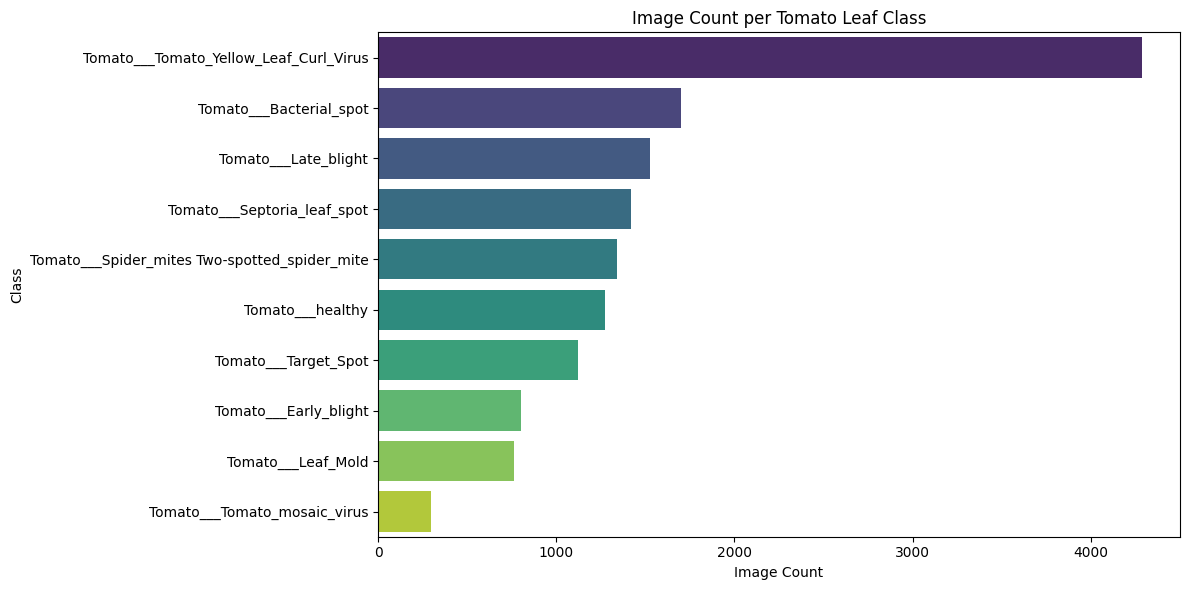

In [6]:


# Count images per class (excluding nested folders)
class_counts = {
    cls: len(os.listdir(os.path.join(root_path, cls)))
    for cls in class_names
}
df_counts = pd.DataFrame(class_counts.items(), columns=["Class", "Image Count"])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_counts.sort_values("Image Count", ascending=False), x="Image Count", y="Class", palette="viridis")
plt.title("Image Count per Tomato Leaf Class")
plt.tight_layout()
plt.show()


In [7]:
df_counts

,Class,Image Count
0,Tomato___Target_Spot,1123
1,Tomato___Leaf_Mold,761
2,Tomato___Early_blight,800
3,Tomato___healthy,1273
4,Tomato___Late_blight,1527
5,Tomato___Tomato_Yellow_Leaf_Curl_Virus,4286
6,Tomato___Septoria_leaf_spot,1417
7,Tomato___Bacterial_spot,1702
8,Tomato___Tomato_mosaic_virus,299
9,Tomato___Spider_mites Two-spotted_spider_mite,1341


**Preprocessing**

In [8]:

# Only use valid root folder
transform = transforms.Compose([
    transforms.Resize((228, 228)),
    transforms.ToTensor()
])

dataset = ImageFolder(root=root_path, transform=transform)

print(f" Dataset size: {len(dataset)}")
print(f" Valid classes: {dataset.classes}")


 Dataset size: 29058
 Valid classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy', 'plantvillage']


In [9]:
import os

# Correct paths
outer_dir = "/content/tomato_leaf_dataset/plantvillage"
inner_dir = "/content/tomato_leaf_dataset/plantvillage/plantvillage"

# Get class names (assumes both have same class folders)
class_names = sorted([d for d in os.listdir(outer_dir)
                      if os.path.isdir(os.path.join(outer_dir, d)) and d != "plantvillage"])

# Verify differences
diff_summary = []

for cls in class_names:
    outer_cls_path = os.path.join(outer_dir, cls)
    inner_cls_path = os.path.join(inner_dir, cls)

    outer_imgs = set(os.listdir(outer_cls_path)) if os.path.exists(outer_cls_path) else set()
    inner_imgs = set(os.listdir(inner_cls_path)) if os.path.exists(inner_cls_path) else set()

    diff_summary.append({
        "Class": cls,
        "Outer Count": len(outer_imgs),
        "Inner Count": len(inner_imgs),
        "Shared": len(outer_imgs & inner_imgs),
        "Outer Only": len(outer_imgs - inner_imgs),
        "Inner Only": len(inner_imgs - outer_imgs)
    })

import pandas as pd
pd.DataFrame(diff_summary)


,Class,Outer Count,Inner Count,Shared,Outer Only,Inner Only
0,Tomato___Bacterial_spot,1702,1702,1702,0,0
1,Tomato___Early_blight,800,800,800,0,0
2,Tomato___Late_blight,1527,1527,1527,0,0
3,Tomato___Leaf_Mold,761,761,761,0,0
4,Tomato___Septoria_leaf_spot,1417,1417,1417,0,0
5,Tomato___Spider_mites Two-spotted_spider_mite,1341,1341,1341,0,0
6,Tomato___Target_Spot,1123,1123,1123,0,0
7,Tomato___Tomato_Yellow_Leaf_Curl_Virus,4286,4286,4286,0,0
8,Tomato___Tomato_mosaic_virus,299,299,299,0,0
9,Tomato___healthy,1273,1273,1273,0,0


In [10]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
original_root = "tomato_leaf_dataset/plantvillage"
cleaned_root = "/content/cleaned_tomato_dataset"
split_ratio = 0.2  # 80% train, 20% val

# Get class names
class_names = [cls for cls in os.listdir(original_root)
               if os.path.isdir(os.path.join(original_root, cls)) and cls != "plantvillage"]

# Recreate cleaned dataset structure
for split in ["train", "val"]:
    for cls in class_names:
        os.makedirs(os.path.join(cleaned_root, split, cls), exist_ok=True)

# Split and copy images
for cls in class_names:
    cls_path = os.path.join(original_root, cls)
    images = os.listdir(cls_path)
    train_imgs, val_imgs = train_test_split(images, test_size=split_ratio, random_state=42)

    for img in train_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(cleaned_root, "train", cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(cleaned_root, "val", cls, img))

print(" Dataset split and organized successfully!")


 Dataset split and organized successfully!


Found 11618 images belonging to 10 classes.
Found 2911 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 68s 170ms/step - accuracy: 0.4109 - loss: 1.7301 - val_accuracy: 0.7042 - val_loss: 0.8739
Epoch 2/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 60s 164ms/step - accuracy: 0.6815 - loss: 0.9284 - val_accuracy: 0.7162 - val_loss: 0.8626
Epoch 3/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 57s 158ms/step - accuracy: 0.7435 - loss: 0.7307 - val_accuracy: 0.6936 - val_loss: 0.9273
Epoch 4/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 58s 159ms/step - accuracy: 0.7829 - loss: 0.6386 - val_accuracy: 0.7963 - val_loss: 0.5743
Epoch 5/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 57s 156ms/step - accuracy: 0.8085 - loss: 0.5517 - val_accuracy: 0.8396 - val_loss: 0.4668
Epoch 6/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 57s 156ms/step - accuracy: 0.8318 - loss: 0.4887 - val_accuracy: 0.8475 - val_loss: 0.4448
Epoch 7/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 58s 159ms/step - accuracy: 0.8326 - loss: 0.4939 - val_accuracy: 0.8533 - val_loss: 0.4539
Epoch 8/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 58s 159ms/step - accuracy: 0.8364 - loss: 0

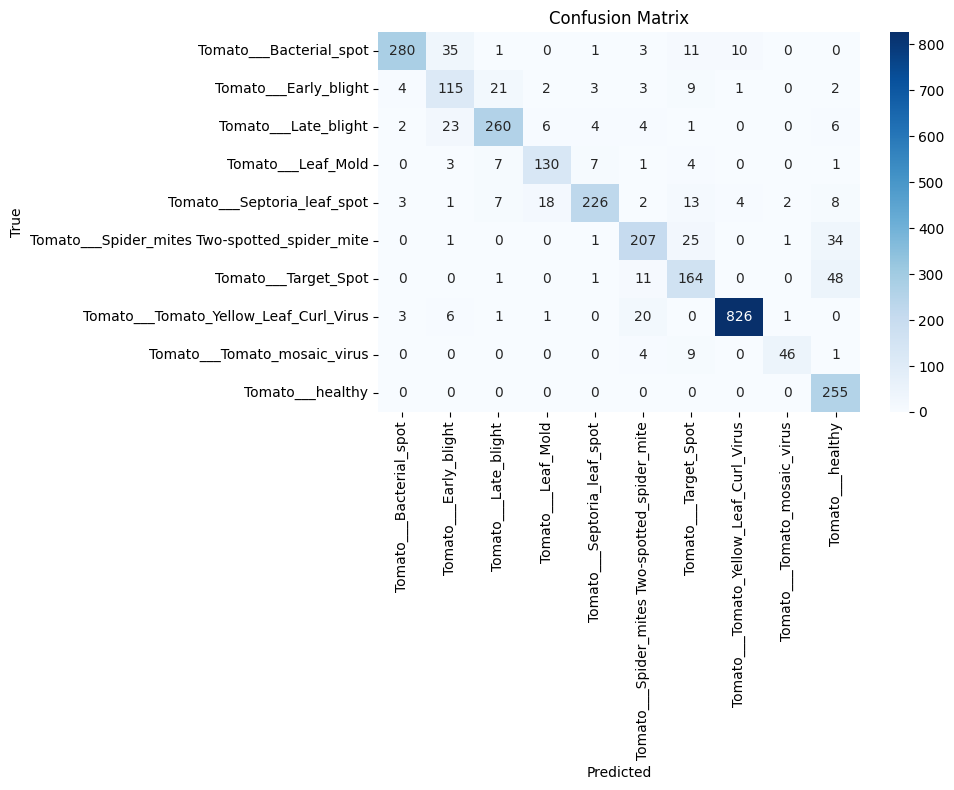

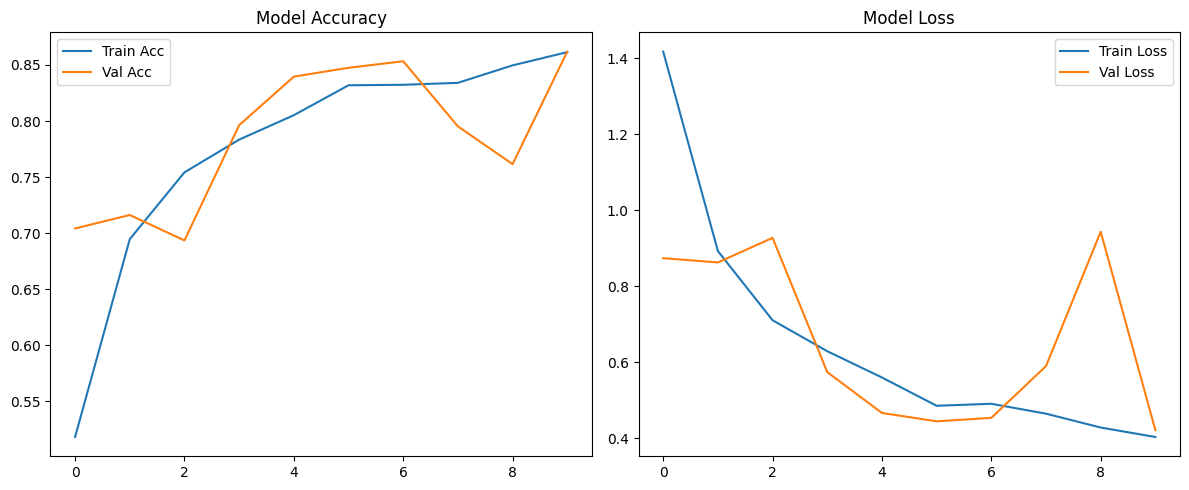

In [11]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
train_dir = "/content/cleaned_tomato_dataset/train"
val_dir = "/content/cleaned_tomato_dataset/val"
img_size = (128, 128)
batch_size = 32

# Image generators
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_loader = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_loader = val_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

# Model
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'), layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'), layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'), layers.MaxPooling2D(2, 2),
    layers.Flatten(), layers.Dense(128, activation='relu'), layers.Dropout(0.5),
    layers.Dense(len(train_loader.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(train_loader, validation_data=val_loader, epochs=10)


# Evaluation: predictions
y_pred = model.predict(val_loader)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_loader.classes
class_labels = list(val_loader.class_indices.keys())

# Classification report
print("\\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Accuracy and loss plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.tight_layout()
plt.show()



